In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 

In [2]:
import tensorflow as tf
import numpy as np
import math
import random
import torch

In [3]:
((train_x, train_y),(eval_x, eval_y)) = tf.keras.datasets.mnist.load_data()
train_x = train_x/np.float32(255)
eval_x = eval_x/np.float32(255)

<h3>Helper Functions</h3>

In [4]:
class HParams(object):
    def __init__(self, **kwargs):
        self.dict_ = kwargs
        self.__dict__.update(self.dict_)

    def update_config(self, in_string):
        pairs = in_string.split(",")
        pairs = [pair.split("=") for pair in pairs]
        for key, val in pairs:
            self.dict_[key] = type(self.dict_[key])(val)
        self.__dict__.update(self.dict_)
        return self

    def __getitem__(self, key):
        return self.dict_[key]

    def __setitem__(self, key, val):
        self.dict_[key] = val
        self.__dict__.update(self.dict_)


def get_default_hparams():
    return HParams(
        image_dim = 28,
        epoch_num = 50,
        batch_size = 1000,
        learning_rate = 1e-3,
        next_batch = 0)

In [5]:
def conv_pool(inputs, filters=32, kernel_size=[5,5], pool_size=[2,2]):
    conv = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding="same",
        activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(inputs=conv, pool_size=pool_size, strides=2)
    return pool

def dense_layer(inputs, reshape=(7,7,64), units=1024, drop_out=True, drop_out_rate=0.4, training=True):
    inputs = tf.reshape(inputs, [-1, reshape[0]*reshape[1]*reshape[2]])
    dense = tf.layers.dense(inputs=inputs, units=units, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=drop_out_rate, training=training)
    return dropout

In [6]:
def cnn_model(inputs, training=True):
    with tf.variable_scope("cnn_model", reuse=tf.AUTO_REUSE):
        inputs = tf.expand_dims(inputs, 3)
        conv1 = conv_pool(inputs)
        conv2 = conv_pool(conv1, filters=64)
        dense = dense_layer(conv2, training=training)
        logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [7]:
def get_batch(data, batch_num, batch_size=100):
    if batch_size == 0:
        raise ValueError("batch_size cannot be zero")
    elif batch_num < 0:
        raise ValueError("batch_num must be larger than or equal to zero")
    elif data is np.ndarray:
        raise TypeError("input data should be numpy.ndarray")
    elif data.shape[0] < batch_size:
        raise TypeError("please reduce the batch_size less than the data number")
    number_of_batch = data.shape[0]//batch_size
    if batch_num >= number_of_batch:
        end_of_batch = True
    else:
        end_of_batch = False
    batch_num = batch_num % number_of_batch
    return data[batch_num*batch_size:(batch_num+1)*batch_size], end_of_batch

In [8]:
def training(train_x, train_y, hps, 
             restore=False, save=False, clean_graph=False, 
             sess=tf.Session(), path="./trained_model", filename="model.ckpt"):
    inputs = tf.placeholder(tf.float32, shape=(None, hps.image_dim, hps.image_dim))
    labels = tf.placeholder(tf.int32, shape=(None))
    logits = cnn_model(inputs)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    optimizer = tf.train.AdamOptimizer(learning_rate=hps.learning_rate).minimize(loss)
    saver = tf.train.Saver()

    sess.run([tf.global_variables_initializer()])
    if restore:
        saver.restore(sess, "{0}/{1}".format(path, filename))

    for epoch in range(hps.epoch_num):
        next_batch = hps.next_batch
        while True:
            train_data, end_of_batch = get_batch(train_x, batch_size=hps.batch_size, batch_num=next_batch)
            train_labels, _ = get_batch(train_y, batch_size=hps.batch_size, batch_num=next_batch)
            next_batch += 1
            sess.run(optimizer, feed_dict={inputs: train_data, labels: train_labels})
            loss_run_time = sess.run(loss, feed_dict={inputs: train_data, labels: train_labels})
            if end_of_batch:
                break
        print("Epoch: {}, Loss:{}".format(epoch, loss_run_time))
    if save:
        save_path = saver.save(sess, "{0}/{1}".format(path, filename))
        print("Model is saved to {0}".format(save_path))
        

In [9]:
def evaluation(eval_x, eval_y, hps, 
               sess=tf.Session(),
               path="./trained_model", filename="model.ckpt", print_output=True):
    inputs = tf.placeholder(tf.float32, shape=(None, hps.image_dim, hps.image_dim))
    labels = tf.placeholder(tf.int32, shape=(None))
    logits = cnn_model(inputs, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    saver = tf.train.Saver()
    sess.run([tf.global_variables_initializer()])
    saver.restore(sess, "./trained_model/model.ckpt")
    loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: eval_x, labels: eval_y})
    accuracy = 100 * np.sum(np.argmax(logits_run_time, axis=1) == eval_y) / eval_y.shape[0]
    if print_output:
        print("Loss:{}, Accuracy:{}%".format(loss_run_time, accuracy))
    return logits_run_time, eval_y

In [10]:
def evaluation_model(hps, 
               sess=tf.Session(),
               path="./trained_model", 
               filename="model.ckpt"):
    inputs = tf.placeholder(tf.float32, shape=(None, hps.image_dim, hps.image_dim))
    labels = tf.placeholder(tf.int32, shape=(None))
    logits = cnn_model(inputs, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    saver = tf.train.Saver()
    sess.run([tf.global_variables_initializer()])
    saver.restore(sess, "./trained_model/model.ckpt")
    return inputs, labels, logits, loss

In [12]:
def uniform_perturbation(sample, x_min, x_max, n=1, sigma=1, seed=0, image_size=28):
    import torch
    import torch.distributions as dist
    sample = torch.tensor(sample).view(-1, image_size*image_size)
    if isinstance(x_min, (int, float, complex)) and isinstance(x_max, (int, float, complex)):
        prior = dist.Uniform(low=torch.max(sample-sigma, torch.tensor([x_min])), high=torch.min(sample+sigma, torch.tensor([x_max])))
    elif isinstance(x_min, torch.Tensor) and isinstance(x_max, torch.Tensor):
        prior = dist.Uniform(low=torch.max(sample-sigma, x_min), high=torch.min(sample+sigma, x_max))
    else:
        raise ValueError('Type of x_min and x_max {0} is not supported'.format(type(x_min)))
    x = prior.sample(torch.Size([n])).view(-1, image_size, image_size)
    return x.numpy(), prior

In [13]:
def show_grey_scale_numpy_array(array):
    import matplotlib.pyplot as plt
    %matplotlib inline  
    imgplot = plt.imshow(array, cmap='gray')

In [14]:
def compute_property_function(logits, labels):
    equal_to_labels = logits.argmax(axis=1) == labels
    correct_logits = np.array([logits[idx][label] for idx, label in enumerate(labels)]) 
    z_c = np.exp(correct_logits)/np.exp(logits).sum(axis=1)
    logits_rankings = np.argsort(logits, axis=1)
    best_logits_without_labels = np.array([logit[logits_ranking[-2]] if equal_to_label else logit[logits_ranking[-1]] 
                                           for logit, logits_ranking, equal_to_label in zip(logits, logits_rankings, equal_to_labels)])
    z_i = np.exp(best_logits_without_labels)/np.exp(logits).sum(axis=1)
    return z_i - z_c

In [15]:
def get_s_xn(samples, input_labels):
    tf.reset_default_graph()
    with tf.Session() as sess:
        inputs, labels, logits, loss = evaluation_model(get_default_hparams(), sess=sess)
        loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: samples, labels: input_labels})
        s_xn = compute_property_function(logits_run_time, perturbated_labels)
    return s_xn

In [16]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [17]:
# The bounds in NN-space
x_min = (0-0.1307)/0.3081
x_max = (1-0.1307)/0.3081

In [18]:
x_max

2.82148653034729

In [19]:
tf.reset_default_graph()
with tf.Session() as sess:
    logits, labels = evaluation(eval_x, eval_y, get_default_hparams(), sess=sess)

INFO:tensorflow:Restoring parameters from ./trained_model/model.ckpt
Loss:0.025718383491039276, Accuracy:99.35%


In [20]:
sample_idx = random.randrange(0, eval_x.shape[0])
sample_x, sample_y = eval_x[sample_idx], eval_y[sample_idx]

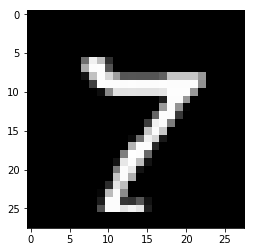

In [21]:
show_grey_scale_numpy_array(sample_x)

In [22]:
sigma = 0.6

<h3>Naive MCMC</h3>

In [33]:
import time
start_time = time.time()
tf.reset_default_graph()
accuracy_list = []
step = 0
sample_size = 10000
repeat = 1000
with tf.Session() as sess:
    inputs, labels, logits, loss = evaluation_model(get_default_hparams(), sess=sess)
    for i in range(repeat):
        perturbated_samples, _ = uniform_perturbation(sample_x, x_min, x_max, n=sample_size, sigma=sigma)
        perturbated_labels = np.repeat(sample_y, sample_size)
        loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: perturbated_samples, labels: perturbated_labels})
        accuracy = 100 * np.sum(np.argmax(logits_run_time, axis=1) == perturbated_labels) / perturbated_labels.shape[0]
        accuracy_list += [accuracy/100]
        update_progress(i / repeat)
    update_progress(1)
end_time = time.time()
run_time = end_time - start_time
print("Run time: {0}s | Average accuracy: {1}".format(run_time, np.array(accuracy_list).mean()))

Progress: [####################] 100.0%
Run time: 448.9420118331909s | Average accuracy: 0.9980725000000001


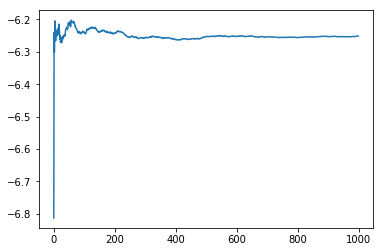

In [34]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
error_list = (1 - np.array(accuracy_list))
log_i_history = [np.log(error_list[:i].mean()) for i in range(1, len(error_list))]
plt.plot(range(len(log_i_history)), log_i_history)

In [36]:
np.array(log_i_history).mean()

-6.250854057006914

<h3>Adaptive Multi-level Splitting</h3>

In [28]:
def mh_update(samples, sample_labels, width_proposal, prior, l_k, inputs, labels, 
              width_inc=1.02, width_dec=0.5, update_steps=250, sess=tf.Session()):
    #Take reference to the original code from the paper, which provides a efficient method for MH process
    import torch
    import torch.distributions as dist
    sample_size = samples.shape[0]
    x = torch.tensor(samples).view(-1, 28*28)
    acc_ratio = torch.zeros(sample_size)
    for i in range(update_steps):
        g_bottom = dist.Uniform(low=torch.max(x - width_proposal.unsqueeze(-1), prior.low), high=torch.min(x + width_proposal.unsqueeze(-1), prior.high))
        x_new = g_bottom.sample()
        loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: x_new.view(-1, 28, 28).numpy(), 
                                                                             labels: sample_labels})
        s_xn = compute_property_function(logits_run_time, sample_labels)
        
        g_top = dist.Uniform(low=torch.max(x_new - width_proposal.unsqueeze(-1), prior.low), high=torch.min(x_new + width_proposal.unsqueeze(-1), prior.high))
        lg_alpha = (prior.log_prob(x_new) - prior.log_prob(x)+ g_top.log_prob(x) - g_bottom.log_prob(x_new)).sum(dim=1)
        acceptance = torch.min(lg_alpha, torch.zeros_like(lg_alpha))
        
        log_u = torch.log(torch.rand_like(acceptance))
        acc_idx = torch.tensor((log_u <= acceptance).numpy() & (s_xn >= l_k))
        acc_ratio += acc_idx.float()
        x = torch.where(acc_idx.unsqueeze(-1), x_new, x)
    width_proposal = torch.where(acc_ratio > 0.124, width_proposal*width_inc, width_proposal)
    width_proposal = torch.where(acc_ratio < 0.124, width_proposal*width_dec, width_proposal)  
    return x.view(-1, 28, 28).numpy(), width_proposal
  

In [29]:
sample_size = 1000
perturbated_samples, prior = uniform_perturbation(sample_x, x_min, x_max, n=sample_size, sigma=sigma)
perturbated_labels = np.repeat(sample_y, sample_size)

In [30]:
quantile = 0.1
log_p_min = -250
l_k = float('-inf')
l_prev = float('-inf')
log_i = 0
k = 0
width_proposal = sigma*torch.ones(sample_size)/30

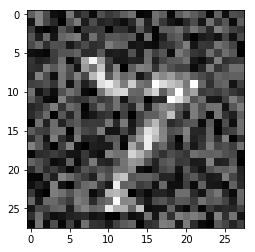

In [31]:
show_grey_scale_numpy_array(perturbated_samples[0])

In [32]:
tf.reset_default_graph()
log_i_record = []
with tf.Session() as sess:
    inputs, labels, logits, loss = evaluation_model(get_default_hparams(), sess=sess)
    while l_k < 0:
        loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: perturbated_samples, labels: perturbated_labels})
        accuracy = 100 * np.sum(np.argmax(logits_run_time, axis=1) == perturbated_labels) / perturbated_labels.shape[0]
        s_xn = compute_property_function(logits_run_time, perturbated_labels)
        l_k = min(0, np.quantile(s_xn, quantile, interpolation='lower'))
        p_k = np.where(s_xn>= l_k)[0].shape[0] / sample_size
        log_i += math.log(p_k)
        if log_i < log_p_min:
            break
        perturbated_samples = perturbated_samples[s_xn>=l_k]
        s_xn = s_xn[s_xn>=l_k]
        resample_idx = np.random.choice(s_xn.shape[0], sample_size)
        perturbated_samples = perturbated_samples[resample_idx]
        s_xn = s_xn[resample_idx]
        logits_run_time = logits_run_time[resample_idx]
        perturbated_samples, width_proposal = mh_update(perturbated_samples, perturbated_labels, width_proposal, prior, 
                                                        l_k, inputs, labels, sess=sess)
        print("Loss:{}, Accuracy:{}%".format(loss_run_time, accuracy))
        print("log_i: {0} | l_k: {1}".format(log_i, l_k))
    

INFO:tensorflow:Restoring parameters from ./trained_model/model.ckpt
Loss:0.008171751163899899, Accuracy:99.9%
log_i: -0.10314075891951337 | l_k: -0.999998152256012
Loss:0.010930454358458519, Accuracy:99.6%
log_i: -0.20739078029331248 | l_k: -0.9999936819076538
Loss:0.011066578328609467, Accuracy:99.7%
log_i: -0.3116408016671116 | l_k: -0.9999831914901733
Loss:0.008763020858168602, Accuracy:100.0%
log_i: -0.41589082304091074 | l_k: -0.9999681115150452
Loss:0.011112280189990997, Accuracy:99.6%
log_i: -0.5201408444147099 | l_k: -0.999944806098938
Loss:0.011730547063052654, Accuracy:99.8%
log_i: -0.624390865788509 | l_k: -0.9999191761016846
Loss:0.013927459716796875, Accuracy:99.6%
log_i: -0.7286408871623081 | l_k: -0.9998655915260315
Loss:0.012479148805141449, Accuracy:99.7%
log_i: -0.8328909085361073 | l_k: -0.999803364276886
Loss:0.01790294051170349, Accuracy:99.7%
log_i: -0.9371409299099064 | l_k: -0.999733567237854
Loss:0.02501867339015007, Accuracy:99.1%
log_i: -1.0413909512837054 |

<h1> Below are Testing </h1>

In [ ]:
get_s_xn(perturbated_samples, perturbated_labels) >= l_k

In [ ]:
######NAIVE MCMC##########

In [ ]:
import torch
import torch.distributions as dist

In [ ]:
samples = perturbated_samples
sample_labels = perturbated_labels
width_inc=1.02
width_dec=0.5
update_steps=250

In [ ]:
sample_size = samples.shape[0]
x = torch.tensor(samples).view(-1, 28*28)
acc_ratio = torch.zeros(sample_size)

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    inputs, labels, logits, loss = evaluation_model(get_default_hparams(), sess=sess)
    loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: perturbated_samples, labels: perturbated_labels})
    accuracy = 100 * np.sum(np.argmax(logits_run_time, axis=1) == perturbated_labels) / perturbated_labels.shape[0]
    s_xn = compute_property_function(logits_run_time, perturbated_labels)


In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    inputs, labels, logits, loss = evaluation_model(get_default_hparams(), sess=sess)
    g_bottom = dist.Uniform(low=torch.max(x - width_proposal.unsqueeze(-1), prior.low), high=torch.min(x + width_proposal.unsqueeze(-1), prior.high))
    x_new = g_bottom.sample()
    loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: x_new.view(-1, 28, 28).numpy(), 
                                                                         labels: sample_labels})
    s_xn = compute_property_function(logits_run_time, sample_labels)

    g_top = dist.Uniform(low=torch.max(x_new - width_proposal.unsqueeze(-1), prior.low), high=torch.min(x_new + width_proposal.unsqueeze(-1), prior.high))
    lg_alpha = (prior.log_prob(x_new) - prior.log_prob(x)+ g_top.log_prob(x) - g_bottom.log_prob(x_new)).sum(dim=1)
    acceptance = torch.min(lg_alpha, torch.zeros_like(lg_alpha))

    log_u = torch.log(torch.rand_like(acceptance))
    acc_idx = torch.tensor((log_u <= acceptance).numpy() & (s_xn >= l_k))
    acc_ratio += acc_idx.float()
    x = torch.where(acc_idx.unsqueeze(-1), x_new, x)
    

In [ ]:
acc_idx

In [ ]:
get_s_xn(perturbated_samples, perturbated_labels)

In [ ]:
if not all(s_x >= l_k for s_x in s_xn):
    print(acc_idx)
    print(s_xn)
    raise ValueError("Bug!")

<h1> Below are Testing </h1>

In [ ]:
sample_quantile = 0.1
termination_threshold = math.exp(-250)
MH_steps = 100

In [ ]:
def mnist_perturbation

In [ ]:
def mnist_perturbation(inputs, mean=0, stddev=0.3, seed=0):
    perturbation = tf.random.normal(shape,mean=0.0,stddev=1.0,dtype=tf.dtypes.float32,seed=None,name="pertubation")
    return inputs

In [ ]:
def mnist_perturbation(data, mean=0, sd=0.3):
    perturbation = np.random.normal(loc=mean, scale=sd, size=data.shape)
    return data+perturbation

In [ ]:
mnist_perturbation(train_x)

In [ ]:
import random
import scipy.stats

In [ ]:
def proposal(x_prior=0):
    return scipy.stats.norm(x_prior,1).rvs()

In [ ]:
def real_density(x):
    if x > 1 or x < 0:
        return 0
    else:
        return 1

In [ ]:
def proposal_ratio(x, x_prior):
    x_prior_against_x = scipy.stats.norm(x,1).pdf(x_prior)
    x_against_x_prior = scipy.stats.norm(x_prior,1).pdf(x)
    return x_prior_against_x/x_against_x_prior

In [ ]:
def real_density_ratio(x, x_prior):
    if x_prior < 0 or x_prior > 1:
        return 1e10
    else:
        return real_density(x)/real_density(x_prior)

In [ ]:
M = 100000
x = proposal(3)
result = []
for i in range(M):
    result += [x]
    x_new = proposal(x)
    alpha = min(1, proposal_ratio(x_new, x)*real_density_ratio(x_new, x))
    u = random.random()
    if u < alpha:
        x = x_new
    else:
        pass

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.hist(result[10000:], bins=20)